In [1]:
import xgboost as xgb
import databento_sql as dbs
import fmp_keymetrics
import combiner

In [2]:
ticker_list = ['AAPL', 'MSFT', 'NVDA',  # Technology
    'AMZN', 'TSLA', 'HD',  # Consumer Discretionary
    'UNH', 'JNJ', 'LLY',  # Healthcare
    'JPM', 'BAC', 'WFC',  # Financials
    'XOM', 'CVX', 'COP',  # Energy
    'PG', 'KO', 'PEP',  # Consumer Staples
    'BA', 'CAT', 'UPS',  # Industrials
    'LIN', 'APD', 'SHW',  # Materials
    'PLD', 'AMT', 'CCI',  # Real Estate
    'NEE', 'DUK', 'SO',  # Utilities
]

In [3]:
# Databento download
for ticker in ticker_list:
    dbs.download_and_append_data(ticker, '2019-01-01', '2023-12-31', frequency='daily')

Ticker AAPL already up-to-date
data/equity/usa/daily/aapl.csv has been successfully zipped into data/equity/usa/daily/aapl.zip.
Data for AAPL fetched from postgres, converted to LEAN format.
Ticker MSFT already up-to-date
data/equity/usa/daily/msft.csv has been successfully zipped into data/equity/usa/daily/msft.zip.
Data for MSFT fetched from postgres, converted to LEAN format.
Ticker NVDA already up-to-date
data/equity/usa/daily/nvda.csv has been successfully zipped into data/equity/usa/daily/nvda.zip.
Data for NVDA fetched from postgres, converted to LEAN format.
Ticker AMZN already up-to-date
data/equity/usa/daily/amzn.csv has been successfully zipped into data/equity/usa/daily/amzn.zip.
Data for AMZN fetched from postgres, converted to LEAN format.
Ticker TSLA already up-to-date
data/equity/usa/daily/tsla.csv has been successfully zipped into data/equity/usa/daily/tsla.zip.
Data for TSLA fetched from postgres, converted to LEAN format.
Ticker HD already up-to-date
data/equity/usa/

In [4]:
#FMP Download
start_date = '2019-01-01'
end_date = '2024-09-31'

fmp = fmp_keymetrics.funda_ETL()
keymetrics = fmp.download_funda_data(ticker_list, start=start_date, end=end_date)
keymetrics

Data for AAPL already exists in the database for the requested range.
Data for MSFT already exists in the database for the requested range.
Data for NVDA already exists in the database for the requested range.
Data for AMZN already exists in the database for the requested range.
Data for TSLA already exists in the database for the requested range.
Data for HD already exists in the database for the requested range.
Data for UNH already exists in the database for the requested range.
Data for JNJ already exists in the database for the requested range.
Data for LLY already exists in the database for the requested range.
Data for JPM already exists in the database for the requested range.
Data for BAC already exists in the database for the requested range.
Data for WFC already exists in the database for the requested range.
Data for XOM already exists in the database for the requested range.
Data for CVX already exists in the database for the requested range.
Data for COP already exists in

""


In [5]:
# Merge Databento and FMP data
comb = combiner.combine_pvol_funda()
#tickers = ['AAPL','AMZN','GOOGL','MSFT']
merged = comb.merge_pvol_funda(ticker_list)

PriceVol data loaded for AAPL
Fundamental data loaded for AAPL
Price-volume fundamental data for AAPL saved to table comb_pvol_funda.AAPL
PriceVol data loaded for MSFT
Fundamental data loaded for MSFT
Price-volume fundamental data for MSFT saved to table comb_pvol_funda.MSFT
PriceVol data loaded for NVDA
Fundamental data loaded for NVDA
Price-volume fundamental data for NVDA saved to table comb_pvol_funda.NVDA
PriceVol data loaded for AMZN
Fundamental data loaded for AMZN
Price-volume fundamental data for AMZN saved to table comb_pvol_funda.AMZN
PriceVol data loaded for TSLA
Fundamental data loaded for TSLA
Price-volume fundamental data for TSLA saved to table comb_pvol_funda.TSLA
PriceVol data loaded for HD
Fundamental data loaded for HD
Price-volume fundamental data for HD saved to table comb_pvol_funda.HD
PriceVol data loaded for UNH
Fundamental data loaded for UNH
Price-volume fundamental data for UNH saved to table comb_pvol_funda.UNH
PriceVol data loaded for JNJ
Fundamental data 

In [6]:
import pandas as pd
import numpy as np
import ta  # ta-lib or ta for calculating technical indicators
import xgboost as xgb
import combiner

# Initialize combiner instance
comb = combiner.combine_pvol_funda()

def add_technical_indicators(df):
    # Add SMA, EMA
    df['sma_20'] = ta.trend.sma_indicator(df['close'], window=20)
    df['sma_50'] = ta.trend.sma_indicator(df['close'], window=50)
    df['ema_20'] = ta.trend.ema_indicator(df['close'], window=20)
    
    # Add RSI, MACD
    df['rsi_14'] = ta.momentum.rsi(df['close'], window=14)
    df['macd'] = ta.trend.macd(df['close'])
    df['macd_signal'] = ta.trend.macd_signal(df['close'])

    # Add Bollinger Bands
    bollinger = ta.volatility.BollingerBands(df['close'], window=20)
    df['bb_upper'] = bollinger.bollinger_hband()
    df['bb_lower'] = bollinger.bollinger_lband()
    
    # Add Average True Range (ATR)
    df['atr_14'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14)
    
    # Add On-Balance Volume (OBV)
    df['obv'] = ta.volume.on_balance_volume(df['close'], df['volume'])
    
    # Add Stochastic Oscillator (K, D)
    stoch = ta.momentum.stoch(df['high'], df['low'], df['close'], window=14, smooth_window=3)
    df['stoch_k'] = stoch
    df['stoch_d'] = ta.momentum.stoch_signal(df['high'], df['low'], df['close'], window=14, smooth_window=3)
    
    # Remove momentum since it was causing an error
    # Add Williams %R
    df['williams_r'] = ta.momentum.williams_r(df['high'], df['low'], df['close'], lbp=14)
    
    # Add Chaikin Money Flow (CMF)
    df['cmf'] = ta.volume.chaikin_money_flow(df['high'], df['low'], df['close'], df['volume'], window=20)
    
    return df

def prepdata(ticker, start_date, end_date):
    # Retrieve data for the ticker and date range
    data = comb.get_comb_data_from_postgresql(ticker, start_date, end_date)

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Sort the data by date
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')

    # Add technical indicators
    df = add_technical_indicators(df)

    # Calculate log returns as the target variable
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))

    # Drop rows with NaN values in log returns and technical indicators
    df = df.dropna()

    # Define the fundamental columns and technical indicators to use as features
    fundamental_columns = [
        'revenuePerShare', 'netIncomePerShare', 'operatingCashFlowPerShare', 'freeCashFlowPerShare', 
        'cashPerShare', 'bookValuePerShare', 'tangibleBookValuePerShare', 'shareholdersEquityPerShare', 
        'interestDebtPerShare', 'marketCap', 'enterpriseValue', 'peRatio', 'priceToSalesRatio', 
        'pocfratio', 'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales', 'enterpriseValueOverEBITDA', 
        'evToOperatingCashFlow', 'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield', 
        'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio', 'interestCoverage', 
        'incomeQuality', 'dividendYield', 'payoutRatio', 'salesGeneralAndAdministrativeToRevenue', 
        'researchAndDdevelopementToRevenue', 'intangiblesToTotalAssets', 'capexToOperatingCashFlow', 
        'capexToRevenue', 'capexToDepreciation', 'stockBasedCompensationToRevenue', 'grahamNumber', 
        'roic', 'returnOnTangibleAssets', 'grahamNetNet', 'workingCapital', 'tangibleAssetValue', 
        'netCurrentAssetValue', 'investedCapital', 'averageReceivables', 'averagePayables', 
        'averageInventory', 'daysSalesOutstanding', 'daysPayablesOutstanding', 
        'daysOfInventoryOnHand', 'receivablesTurnover', 'payablesTurnover', 'inventoryTurnover', 
        'roe', 'capexPerShare'
    ]
    
    # Technical columns added
    technical_columns = [
        'sma_20', 'sma_50', 'ema_20', 'rsi_14', 'macd', 'macd_signal', 'bb_upper', 'bb_lower', 
        'atr_14', 'obv', 'stoch_k', 'stoch_d', 'williams_r', 'cmf'
    ]

    # Fill missing values in the fundamental columns using forward fill, followed by zeros if necessary
    df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)

    # Define features (X) and target (y)
    X = df[fundamental_columns + technical_columns]
    y = df['log_return']

    # Convert features into an XGBoost DMatrix
    dmat = xgb.DMatrix(X, label=y, missing=np.nan)

    return dmat, y, X

# Example of how to use the updated function
#ticker_list = ['AAPL']
for ticker in ticker_list:
    start_date = '2019-01-01'
    end_date = '2022-12-31'

    # Prepare the training data using log returns
    dtrain, y_train, X_train = prepdata(ticker, start_date, end_date)

    ''' Setting Test Data '''
    start_date = '2023-01-01'
    end_date = '2023-12-31'

    # Prepare the test data
    dtest, y_test, X_test = prepdata(ticker, start_date, end_date)


C:\Users\MP\AppData\Local\Temp\ipykernel_38280\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)
C:\Users\MP\AppData\Local\Temp\ipykernel_38280\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)
C:\Users\MP\AppData\Local\Temp\ipykernel_38280\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)
C:\Users\MP\AppData\Local

: 

In [7]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
from tqdm import tqdm  # Import tqdm for progress bar

# Combine training data for multiple tickers
tickers = ticker_list #tickerlist defined at the top of file
X_combined = []
y_combined = []

# Loop through tickers with progress bar
for ticker in tqdm(tickers, desc="Processing tickers"):
    dtrain, y_train, X_train = prepdata(ticker, '2019-01-01', '2022-12-31')
    X_combined.append(X_train)
    y_combined.append(y_train)

X_combined = pd.concat(X_combined)
y_combined = np.concatenate(y_combined)

# Initialize model and parameter grid
xgb_regressor = XGBRegressor()

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.7, 0.8],
    'alpha': [0.1],
    'lambda': [0.1]
}

# Use TimeSeriesSplit for time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=tscv, scoring='r2', verbose=1)
grid_search.fit(X_combined, y_combined)

# Print the best parameters and R² score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best R² Score: {grid_search.best_score_}")


Processing tickers:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)
Processing tickers:   3%|▎         | 1/30 [00:00<00:06,  4.39it/s]C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)
Processing tickers:   7%|▋         | 2/30 [00:00<00:06,  4.30it/s]C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. 

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'alpha': 0.1, 'colsample_bytree': 0.8, 'lambda': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best R² Score: 0.3946600827811203


In [8]:
import joblib

# Save the best model
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'xgb_best_model.pkl')


['xgb_best_model.pkl']

In [9]:
# Load the saved model
best_model = joblib.load('xgb_best_model.pkl')


In [10]:
# Test the model on new tickers
#new_tickers = ['MSFT', 'GOOG', 'AMZN']  # Example tickers

for ticker in ticker_list:
    # Prepare data for the new ticker
    dtrain, y_train, X_train = prepdata(ticker, '2019-01-01', '2022-12-31')
    
    # Use the saved model to make predictions
    y_pred = best_model.predict(X_train)
    
    # Evaluate model performance
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    mae = mean_absolute_error(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    
    print(f"Performance on {ticker}:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R²: {r2}")
    print('---')


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on AAPL:
MAE: 0.010657280699010603
MSE: 0.00037526202591214663
R²: 0.8437153142562837
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)
C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on MSFT:
MAE: 0.008590097771808674
MSE: 0.00016334083034455678
R²: 0.5687466845124849
---
Performance on NVDA:
MAE: 0.0176413149906086
MSE: 0.0009030613447724581
R²: 0.7152710799489919
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on AMZN:
MAE: 0.011795866266487055
MSE: 0.00097014227203317
R²: 0.9006117757495185
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on TSLA:
MAE: 0.023616065903998035
MSE: 0.0013066846762331264
R²: 0.7602206227971915
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on HD:
MAE: 0.008040456450407272
MSE: 0.00017481392255756212
R²: 0.5129293622001118
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on UNH:
MAE: 0.008125261508538673
MSE: 0.00017278900618272205
R²: 0.5179695273018707
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on JNJ:
MAE: 0.005496376746276928
MSE: 7.295790525543348e-05
R²: 0.5752345149158287
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on LLY:
MAE: 0.008762143548011
MSE: 0.0002019841802803793
R²: 0.5118632793869426
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on JPM:
MAE: 0.009149374493499068
MSE: 0.0002086526137168962
R²: 0.5120988381818674
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on BAC:
MAE: 0.01058799990045791
MSE: 0.000263970680010294
R²: 0.5017011591399136
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on WFC:
MAE: 0.011814055768455636
MSE: 0.0003203411437691773
R²: 0.4981058051950069
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on XOM:
MAE: 0.01112072780864645
MSE: 0.0002554748812809493
R²: 0.5097150466956388
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on CVX:
MAE: 0.010384111844012082
MSE: 0.00028901088294168957
R²: 0.46541873884924734
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on COP:
MAE: 0.014547045718250927
MSE: 0.00048231302184592416
R²: 0.4479582131348734
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on PG:
MAE: 0.005873355284959641
MSE: 9.049945120569165e-05
R²: 0.5688904948006577
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on KO:
MAE: 0.006008964612859914
MSE: 9.335578871358892e-05
R²: 0.4841282712061874
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on PEP:
MAE: 0.005737607837821636
MSE: 9.28179835999123e-05
R²: 0.5395838941945901
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)
C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on BA:
MAE: 0.015475235787178191
MSE: 0.0006765736253497843
R²: 0.44153630880081884
---
Performance on CAT:
MAE: 0.00999169619129688
MSE: 0.00021472024746574923
R²: 0.5174672742984776
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on UPS:
MAE: 0.008951032557025172
MSE: 0.00019624531381675668
R²: 0.5145721594905039
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on LIN:
MAE: 0.007988183598426396
MSE: 0.00014209268007440813
R²: 0.559008185687858
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on APD:
MAE: 0.008467572436725496
MSE: 0.0001853915148741784
R²: 0.5142429543984651
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on SHW:
MAE: 0.009194673922153063
MSE: 0.0002795453614005663
R²: 0.8293856587282377
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on PLD:
MAE: 0.009114489251651694
MSE: 0.00021244633879644013
R²: 0.5100881415500644
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on AMT:
MAE: 0.008386193309042741
MSE: 0.00016884918797085833
R²: 0.5409294472112713
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on CCI:
MAE: 0.008338309903463017
MSE: 0.0001673902469975264
R²: 0.545290022178764
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on NEE:
MAE: 0.008782751598793454
MSE: 0.0003558159817835232
R²: 0.849371196552335
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


Performance on DUK:
MAE: 0.006608495336287914
MSE: 0.00011870214863700954
R²: 0.5191406477182491
---
Performance on SO:
MAE: 0.00705848145124329
MSE: 0.00015106162182581395
R²: 0.49335852529964885
---


C:\Users\MP\AppData\Local\Temp\ipykernel_18220\304463306.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fundamental_columns + technical_columns] = df[fundamental_columns + technical_columns].fillna(method='ffill').fillna(0)


c:\Users\MP\anaconda3\envs\algo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\MP\anaconda3\envs\algo\lib\site-packages\shap\plots\colors\_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
c:\Users\MP\anaconda3\envs\algo\lib\site-packages\shap\plots\colors\_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
c:\Users\MP\anaconda3\envs\algo\lib\site-packages\shap\plots\colors\_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is depre

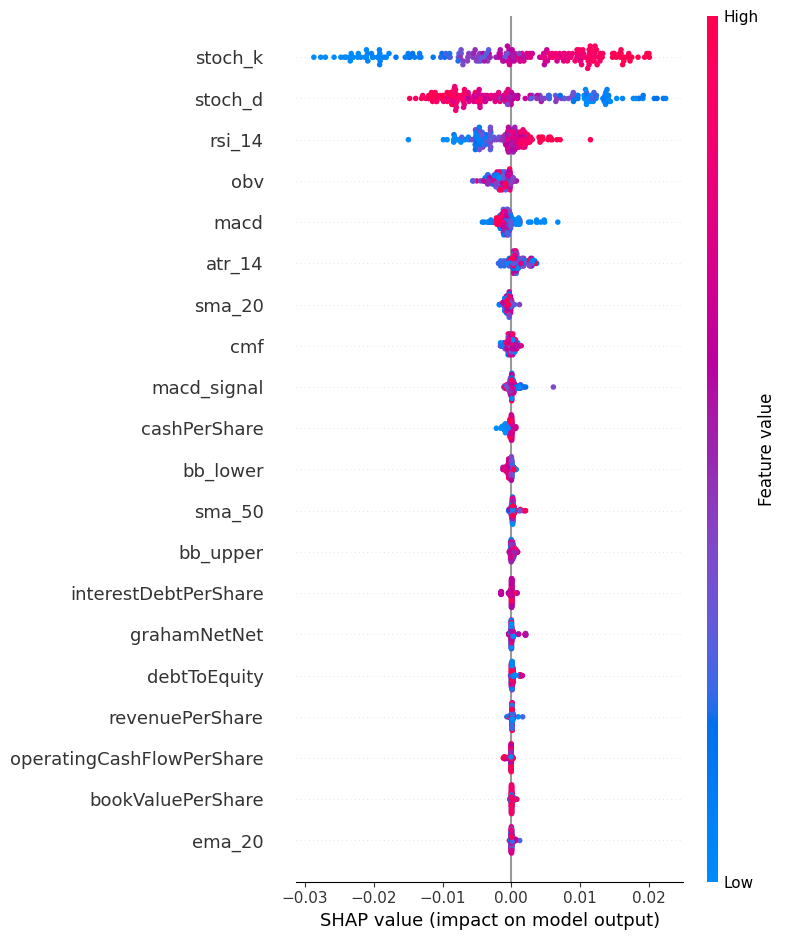

In [11]:
import shap
import xgboost as xgb

# Train the XGBoost model
params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse'
}

# Train the model on the prepared data
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=100)

# Create the SHAP explainer based on your XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Get SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Visualize the feature importance using SHAP
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


In [12]:
# Cross-validation
cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, metrics={'rmse'}, early_stopping_rounds=10)
print(cv_results)


    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          0.014248        0.000304        0.015691       0.001831
1          0.012151        0.000244        0.014526       0.001525
2          0.010606        0.000383        0.013919       0.001337
3          0.009209        0.000422        0.013418       0.001367
4          0.008242        0.000427        0.013124       0.001357
5          0.007388        0.000329        0.012909       0.001404
6          0.006893        0.000335        0.012815       0.001405
7          0.006437        0.000353        0.012853       0.001455
8          0.005978        0.000303        0.012810       0.001516
9          0.005708        0.000355        0.012803       0.001590
10         0.005309        0.000318        0.012675       0.001616
11         0.005035        0.000255        0.012609       0.001600


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

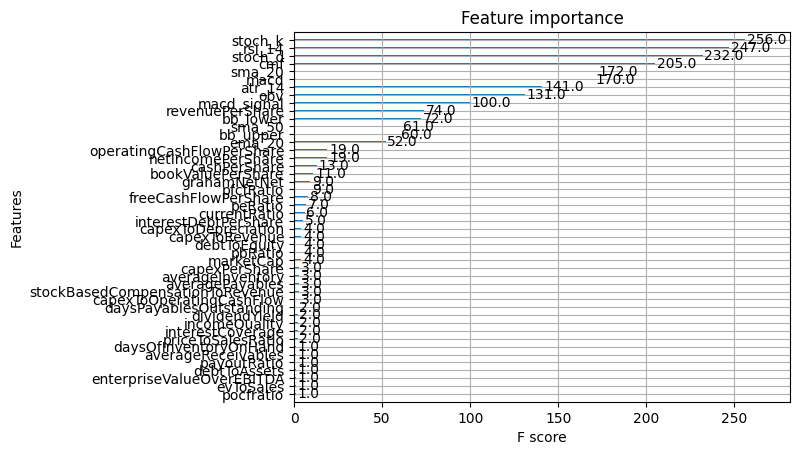

In [14]:
# Plot feature importance
xgb.plot_importance(xgb_model)


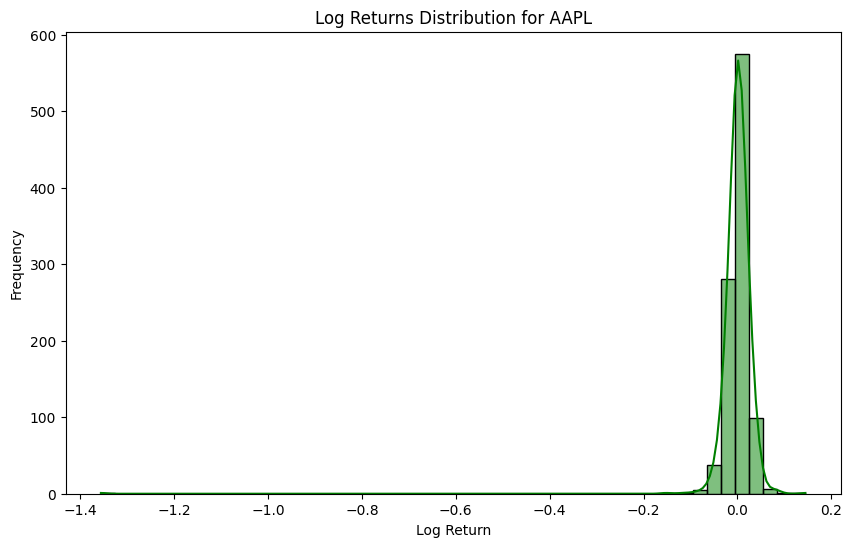

In [15]:
# Visualize Log Returns distribution
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example: calculate log returns
def calculate_log_returns(df):
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df = df.dropna(subset=['log_return'])
    return df

# Retrieve data for a specific ticker (as an example, assuming you already have this)
ticker = 'AAPL'
start_date = '2019-01-01'
end_date = '2022-12-31'

# Fetch data using the combiner (assuming combiner is already initialized)
data = comb.get_comb_data_from_postgresql(ticker, start_date, end_date)
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Calculate log returns
df = calculate_log_returns(df)

# Plot the distribution of log returns
plt.figure(figsize=(10, 6))
sns.histplot(df['log_return'], bins=50, kde=True, color='green')
plt.title(f'Log Returns Distribution for {ticker}')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.show()
